# K-means
Metodo de agrupamiento que divide un conjunto de datos en K-grupos o clusteres apartir de centroides



# Practica

Analizar el archivo analisis.csv donde se evalua a la luz del "Ocean: The Big Five" aspectos de la personalidad de diferentes figuras publicas en X

- Usuario: Nombre de la figura
- OP: Opennes to experience
- CO: Conscientiousness
- EX: Extraversion
- AG: Agreebleness
- NE: Neuroticism
- Wordcount: La cantidad de palabras promedio usadas en los tweets
- Categoria: Actividad laboral del usuario

### Categorias
1. Actor/Actriz
2. Cantante
3. Modelo
4. TV, Series
5. Radio
6. Tecnologia
7. Deportes
8. Politica
9. Escritores

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import *
from sklearn.preprocessing import label_binarize

from mpl_toolkits.mplot3d import Axes3D

import random
import math

plt.rcParams["figure.figsize"] = (16,9)
plt.style.use("ggplot")

In [64]:
dataframe = pd.read_csv(r"analisis.csv")
dataframe.head()

,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4


In [65]:
dataframe.describe()

,op,co,ex,ag,ne,wordcount,categoria
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,44.414591,22.977135,40.764428,22.918528,8.000098,98.715484,4.050000
std,8.425723,5.816851,7.185246,7.657122,3.039248,44.714071,2.658839
min,30.020465,7.852756,18.693542,9.305985,1.030213,5.020800,1.000000
25%,38.206484,19.740299,36.095722,17.050993,6.086144,66.218475,2.000000
50%,44.507091,22.466718,41.457492,21.384554,7.839722,94.711400,3.500000
75%,49.365923,26.091606,45.197769,28.678866,9.758189,119.707925,7.000000
max,71.696129,49.637863,59.824844,40.583162,23.978462,217.183200,9.000000


In [66]:
dataframe.groupby("categoria").size()

categoria
1    27
2    34
3     9
4    19
5     4
6     8
7    17
8    16
9     6
dtype: int64

## Visualizacion de datos

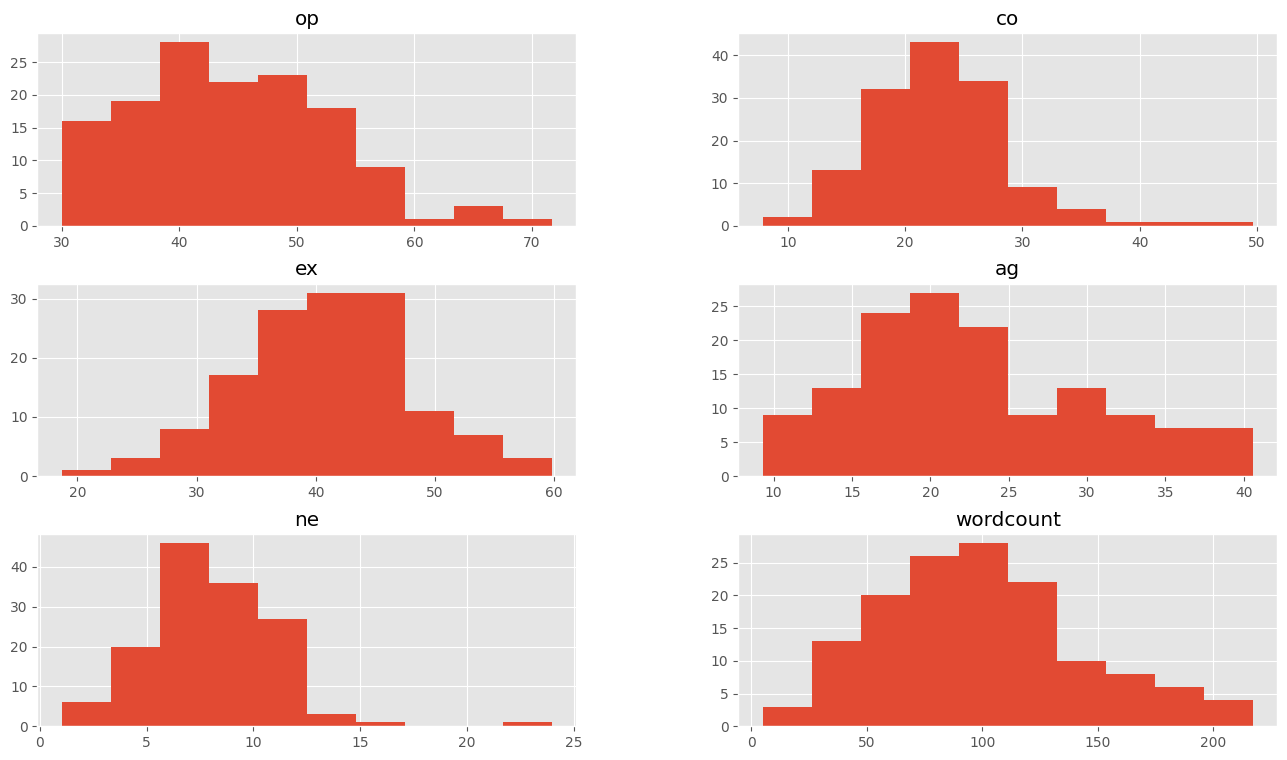

In [67]:
dataframe.drop(columns=["categoria"]).hist()
plt.show()

Se seleccionara como dimensiones 3 columnas del dataset. se cruzara con el fin de encontrar alguna pista de agrupacion y relacion entre categorias

['ne', 'op', 'co']


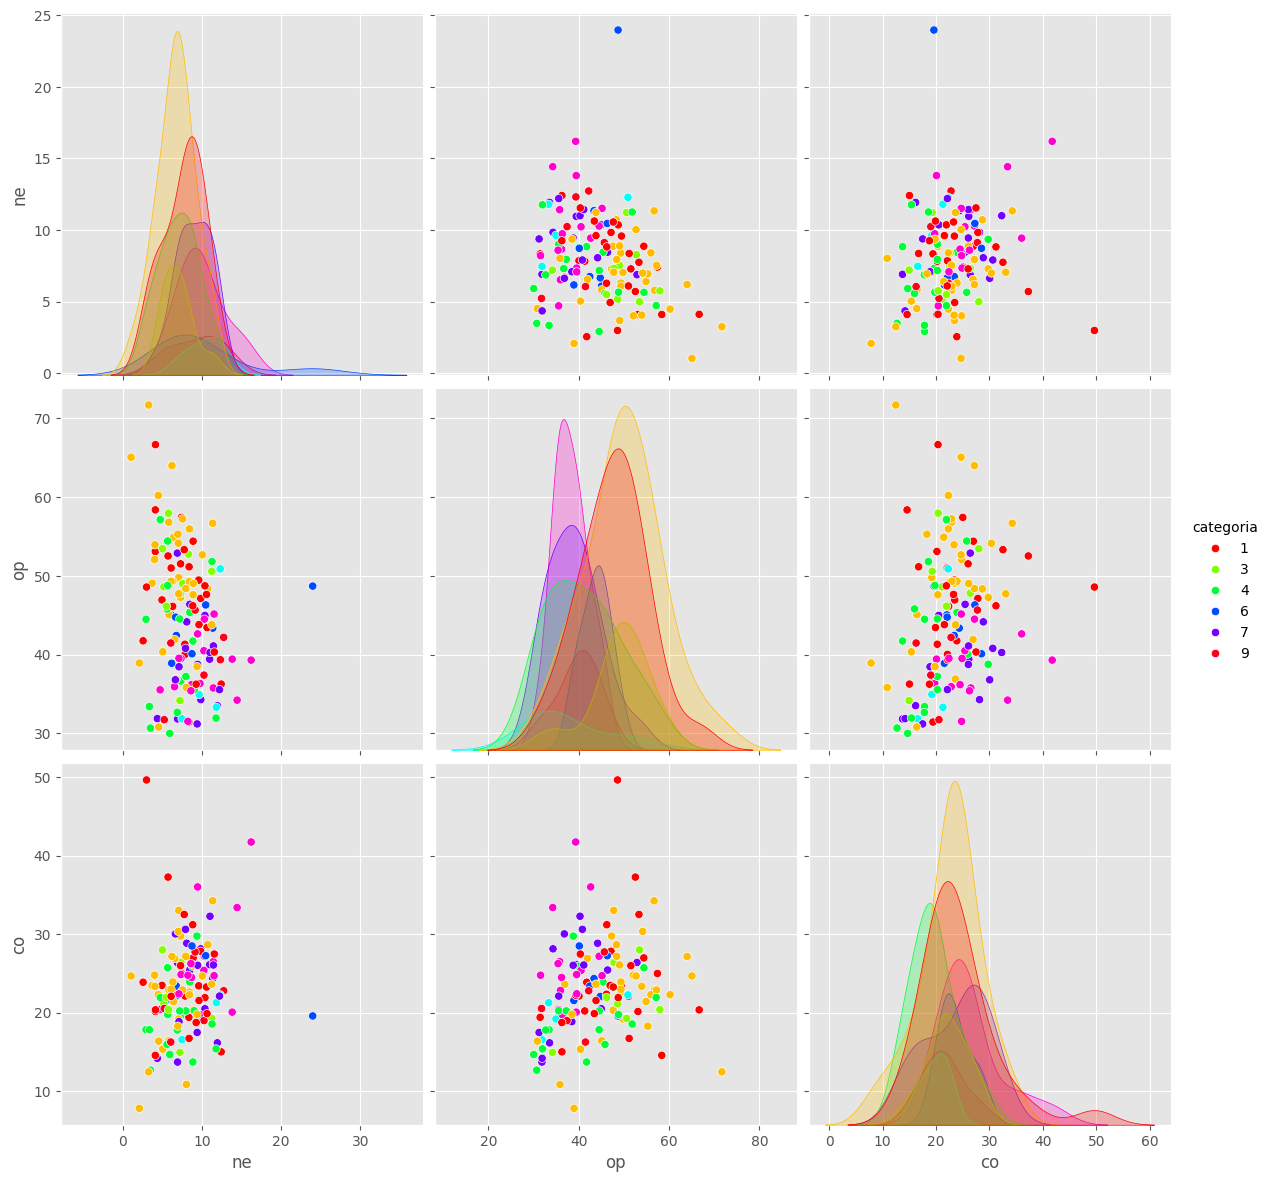

In [68]:
columnas = ["op","ex","ag","co","ne","wordcount"]
# Selecionar 3 columnas al azar
seleccionadas = random.sample(columnas, 3)
print(seleccionadas)
sb.pairplot(dataframe.dropna(), hue="categoria", height= 4, vars=seleccionadas, kind= "scatter", palette= "hsv")

Revisando la grafica, no se observa ningun tipo de agrupacion o correlacion entre los usuarios y sus categorias

## Definicion de entrada
Se concreta la estructura de datos que se empleara para alimentar el algoritmo. se cargan las columnas OP, EX y AG en la variable X

In [69]:
x = np.array(dataframe[seleccionadas])
y = np.array(dataframe["categoria"])
x.shape

(140, 3)

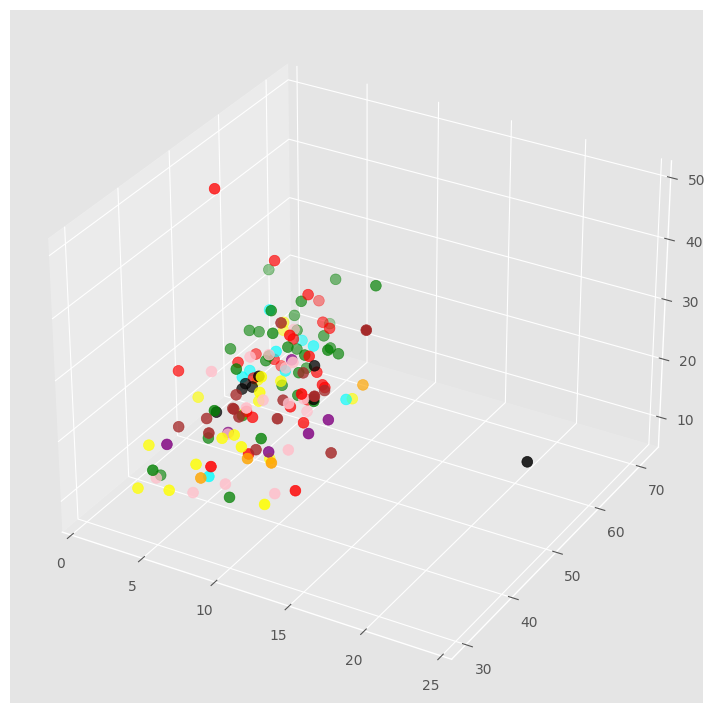

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")

colores=["blue","red","green","cyan","yellow","orange","black","pink","brown","purple"]

asignar=[]
for row in y:
    asignar.append(colores[row])

ax.scatter(x[:,0], x[:,1], x[:,2], c= asignar, s= 60)
plt.show()

## 1. Obtener la cantidad de centroides - Obtener el valor de K

se empleara la metodologia del "punto de codo" para hallar la cantidad de centroides

K elegido por Elbow (heurística): 3
K elegido por Silhouette (máx): 2
K elegido por Calinski-Harabasz (máx): 2
K elegido por Davies-Bouldin (mín): 14


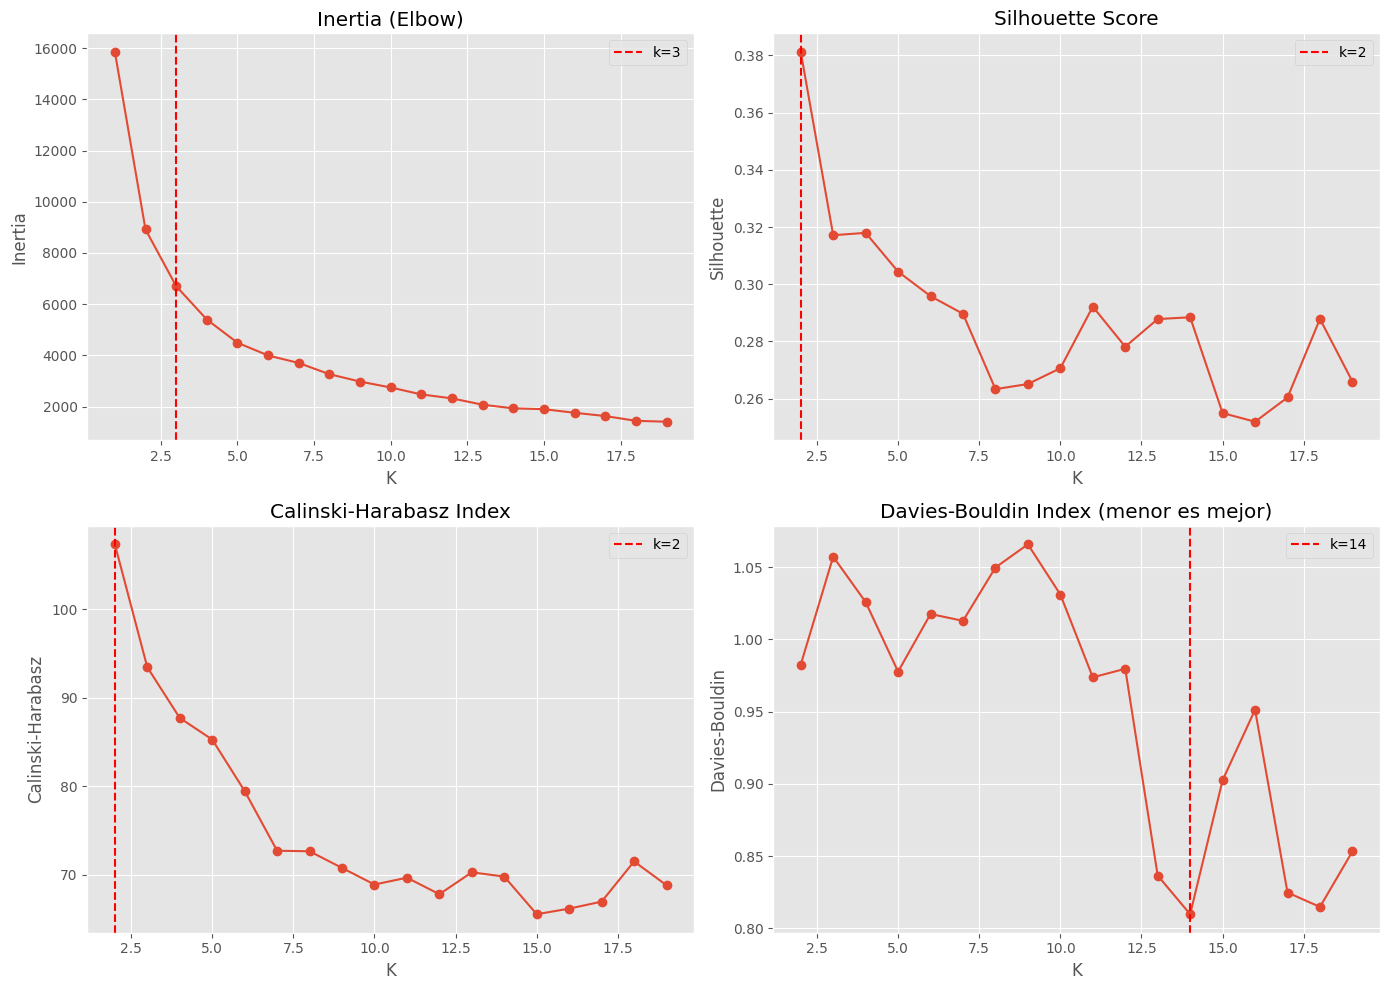

In [ ]:
k = list(range(1, 20))
models = [KMeans(n_clusters=i, random_state=0, n_init=10) for i in k]

# métricas
inertia = []
silhouettes = []
calinski = []
davies = []

for km in models:
    if km.n_clusters == 1:
        km.fit(x)
        inertia.append(km.inertia_)
        silhouettes.append(np.nan)
        calinski.append(np.nan)
        davies.append(np.nan)
    else:
        labels = km.fit_predict(x)
        inertia.append(km.inertia_)
        silhouettes.append(silhouette_score(x, labels))
        calinski.append(calinski_harabasz_score(x, labels))
        davies.append(davies_bouldin_score(x, labels))

# elegir K por cada método:
# - Silhouette: máximo
# - Calinski-Harabasz: máximo
# - Davies-Bouldin: mínimo
# - Elbow (heurística): máximo de la segunda diferencia absoluta de la inercia

sil_best = k[int(np.nanargmax(silhouettes))]
cal_best = k[int(np.nanargmax(calinski))]
dav_best = k[int(np.nanargmin(davies))]

# heurística para elbow
if len(inertia) >= 3:
    second_diff = np.diff(inertia, n=2)  # tamaño len(k)-2
    elbow_idx = int(np.argmax(np.abs(second_diff))) + 2
    elbow_best = k[elbow_idx]
else:
    elbow_best = k[0]

print(f"K elegido por Elbow (heurística): {elbow_best}")
print(f"K elegido por Silhouette (máx): {sil_best}")
print(f"K elegido por Calinski-Harabasz (máx): {cal_best}")
print(f"K elegido por Davies-Bouldin (mín): {dav_best}")

# graficar cada método
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

axes[0].plot(k, inertia, marker='o')
axes[0].set_title('Inertia (Elbow)')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].axvline(elbow_best, color='red', linestyle='--', label=f'k={elbow_best}')
axes[0].legend()

axes[1].plot(k, silhouettes, marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Silhouette')
axes[1].axvline(sil_best, color='red', linestyle='--', label=f'k={sil_best}')
axes[1].legend()

axes[2].plot(k, calinski, marker='o')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].set_xlabel('K')
axes[2].set_ylabel('Calinski-Harabasz')
axes[2].axvline(cal_best, color='red', linestyle='--', label=f'k={cal_best}')
axes[2].legend()

axes[3].plot(k, davies, marker='o')
axes[3].set_title('Davies-Bouldin Index (menor es mejor)')
axes[3].set_xlabel('K')
axes[3].set_ylabel('Davies-Bouldin')
axes[3].axvline(dav_best, color='red', linestyle='--', label=f'k={dav_best}')
axes[3].legend()

plt.tight_layout()
plt.show()

Crear KMeans a partir de los K elegidos por cada método y graficar

In [72]:
ks = {
    "elbow": elbow_best,
    "silhouette": sil_best,
    "calinski": cal_best,
    "davies": dav_best
}

models = {}
for name, k in ks.items():
    km = KMeans(n_clusters=int(k), random_state=0, n_init=10).fit(x)
    models[name] = km
    labels = km.labels_
    counts = np.bincount(labels, minlength=km.n_clusters)
    print(f"{name}: k={k} -> cluster counts: {counts}")
    print(f"{name}: centroides:\n{km.cluster_centers_}\n")

elbow: k=3 -> cluster counts: [43 46 51]
elbow: centroides:
[[ 6.84085942 54.15898758 22.91686993]
 [ 7.72633026 36.25884985 18.4298008 ]
 [ 9.22442235 43.55488561 27.12946473]]

silhouette: k=2 -> cluster counts: [73 67]
silhouette: centroides:
[[ 8.44125784 37.87936834 21.37267708]
 [ 7.51943082 51.53505725 24.72527639]]

calinski: k=2 -> cluster counts: [73 67]
calinski: centroides:
[[ 8.44125784 37.87936834 21.37267708]
 [ 7.51943082 51.53505725 24.72527639]]

davies: k=14 -> cluster counts: [17 12  7 15 16  4 14  2 11  1 18  1 21  1]
davies: centroides:
[[ 9.65659488 38.72023541 27.91057229]
 [ 7.31351217 53.41207892 28.48306642]
 [ 5.18557186 42.56383357 14.792081  ]
 [ 6.97837373 32.21206427 15.93048213]
 [ 8.18848519 43.70260094 22.19832625]
 [ 3.95095475 63.988426   23.6405675 ]
 [ 8.9819315  46.7296995  27.9662915 ]
 [12.8180975  40.979498   38.88333   ]
 [ 5.92450164 56.20109427 21.21919264]
 [ 2.979542   48.587099   49.637863  ]
 [ 7.965349   49.39817156 21.51266933]
 [23.9

Graficar cada modelo

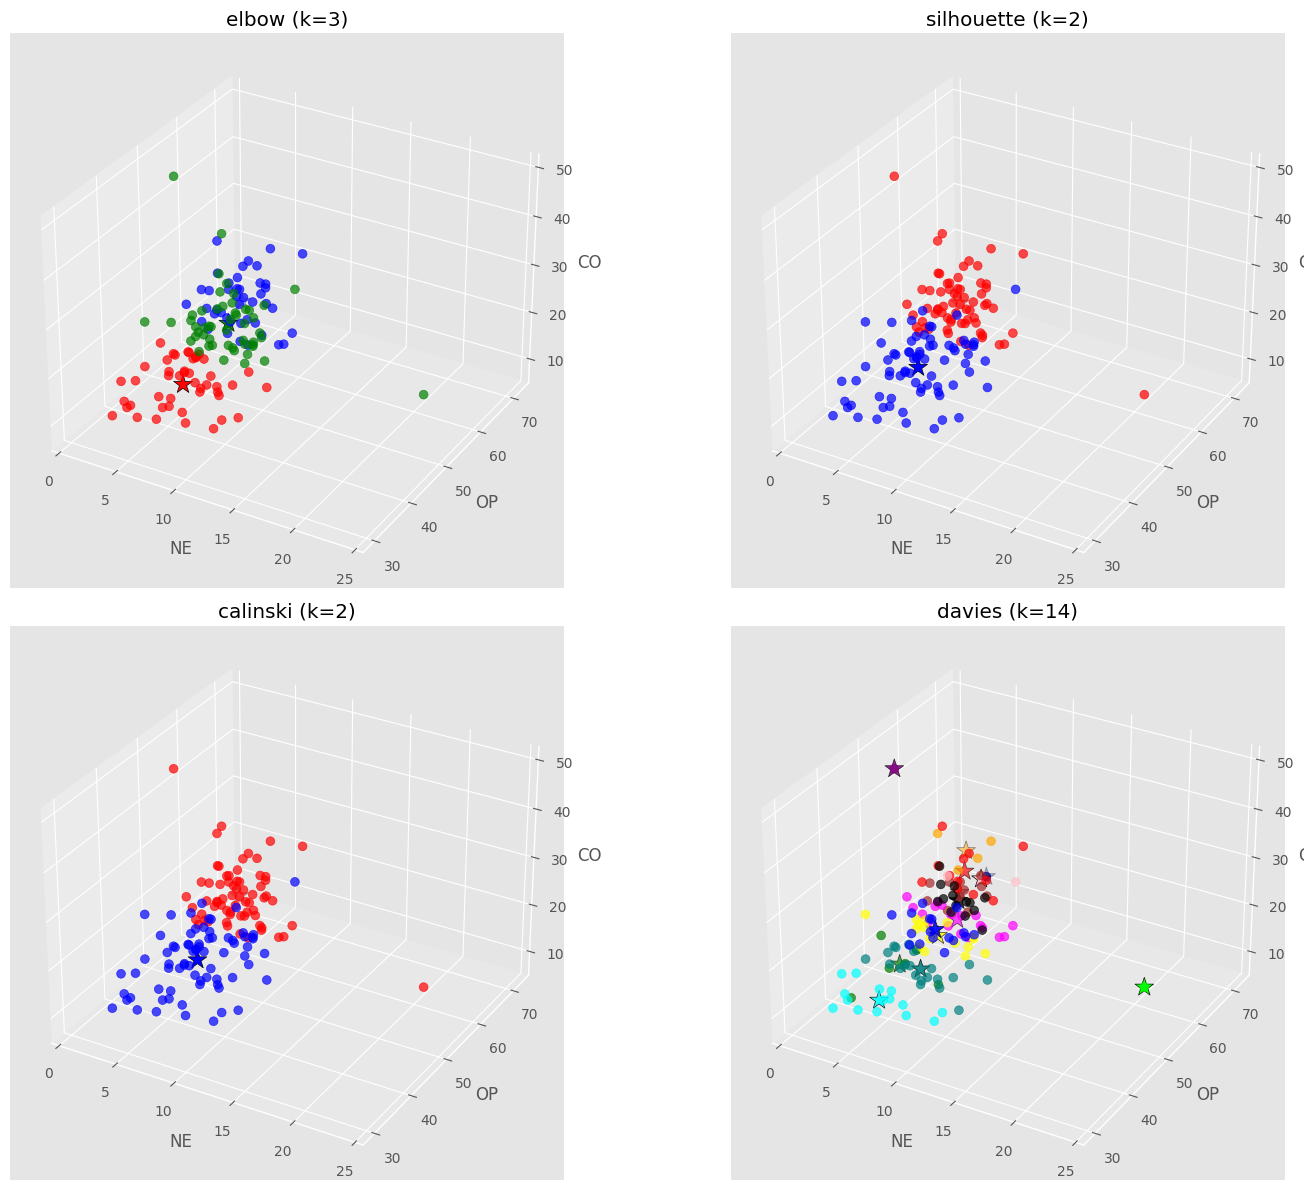

In [73]:
fig = plt.figure(figsize=(16, 12))
colores = ["blue","red","green","cyan","yellow","orange","black","pink","brown","purple", "magenta", "lime", "teal", "navy", "maroon", "olive", "coral", "gold", "silver", "violet", "indigo", "turquoise", "salmon", "plum", "orchid", "tan", "lavender", "beige", "peach", "mint", "apricot", "charcoal", "ivory"]

for i, (name, km) in enumerate(models.items(), start=1):
    ax = fig.add_subplot(2, 2, i, projection="3d")
    labels = km.predict(x)
    
    asignar = [colores[l] if l < len(colores) else "gray" for l in labels]
    C = km.cluster_centers_
    ax.scatter(x[:,0], x[:,1], x[:,2], c=asignar, s=40, alpha=0.7)
    ax.scatter(C[:,0], C[:,1], C[:,2], marker="*", c=colores[:km.n_clusters], s=200, edgecolor="k")
    ax.set_title(f"{name} (k={km.n_clusters})")
    ax.set_xlabel(seleccionadas[0].upper())
    ax.set_ylabel(seleccionadas[1].upper())
    ax.set_zlabel(seleccionadas[2].upper())

plt.tight_layout()
plt.show()

Se puede observar como KMeans ha agrupado 140 usuarios de x en 5 clusteres de acuerdo a la personalidad de Openess, Extraversion, Agreableness.

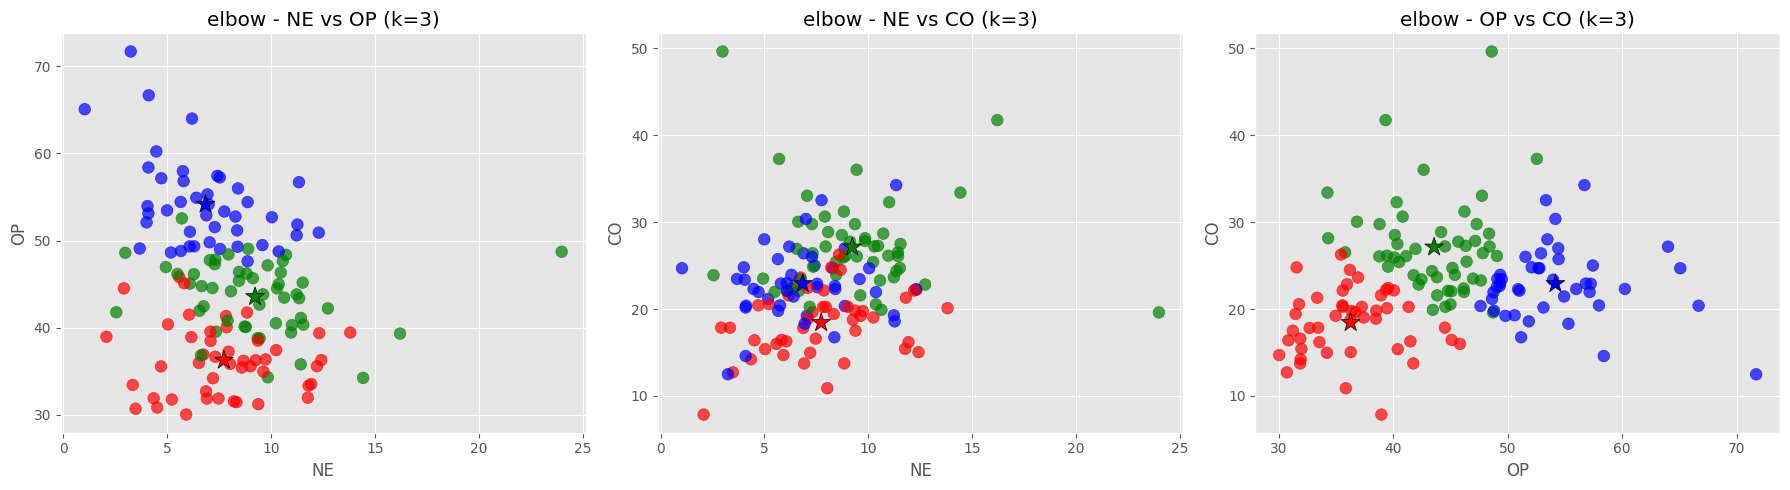

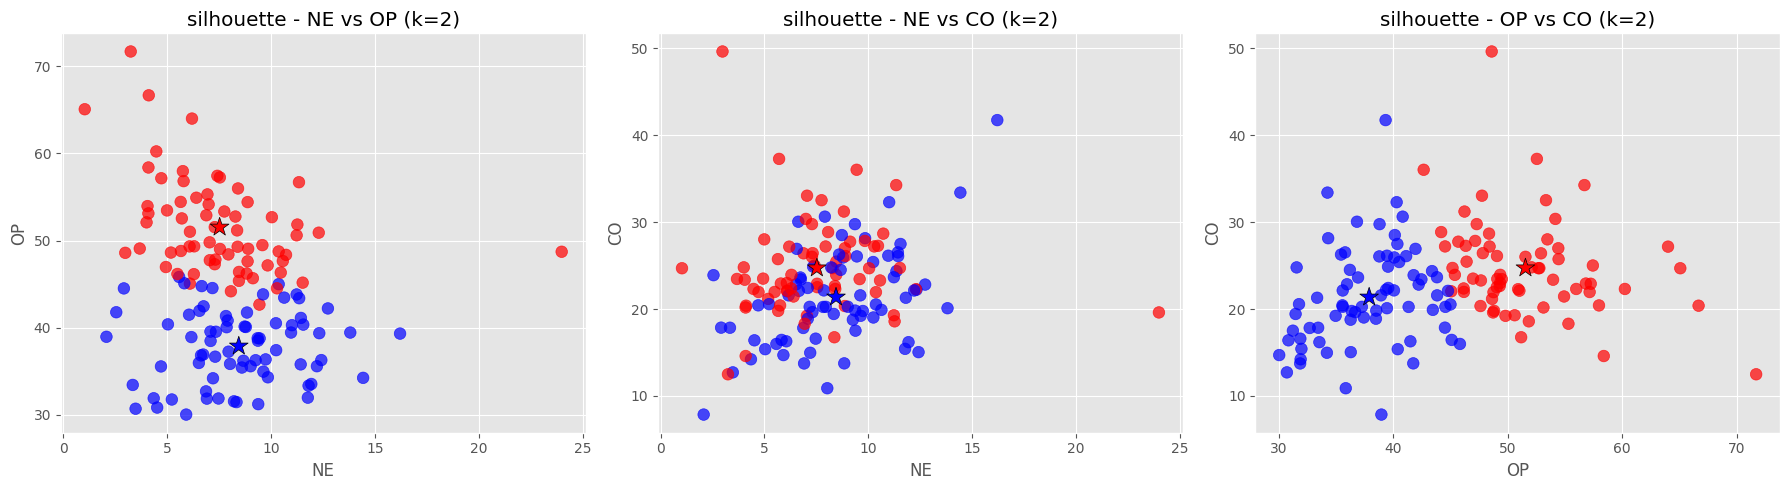

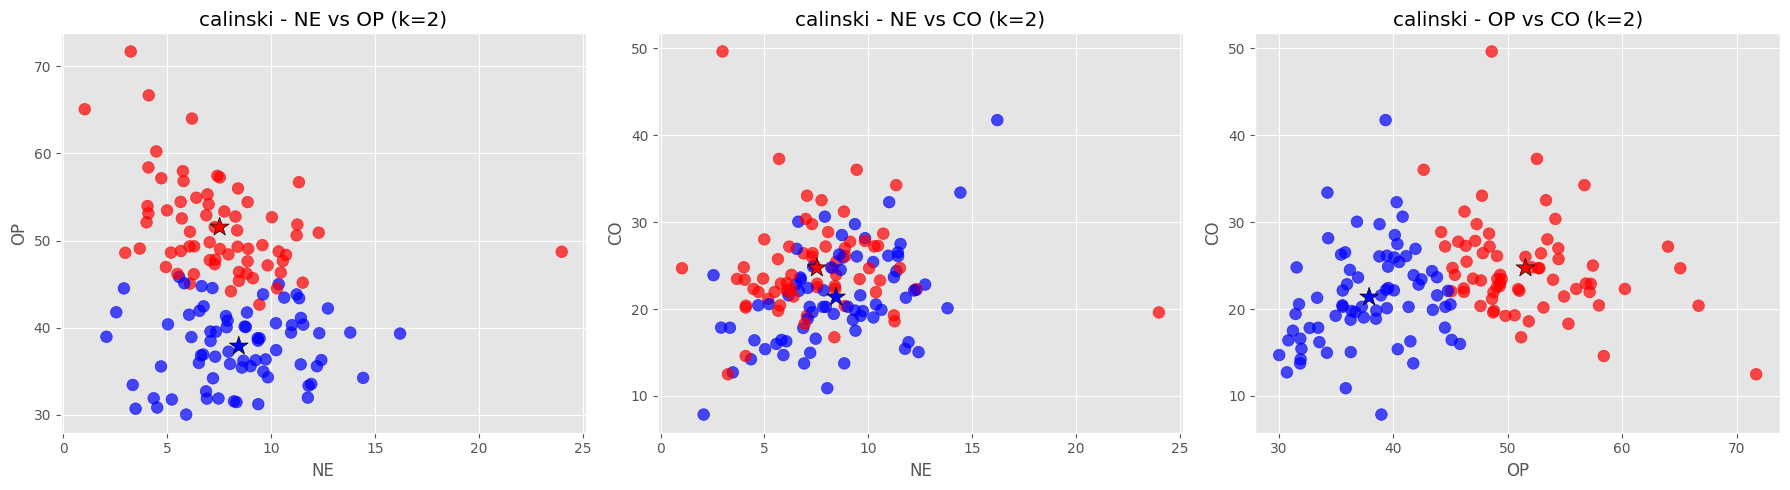

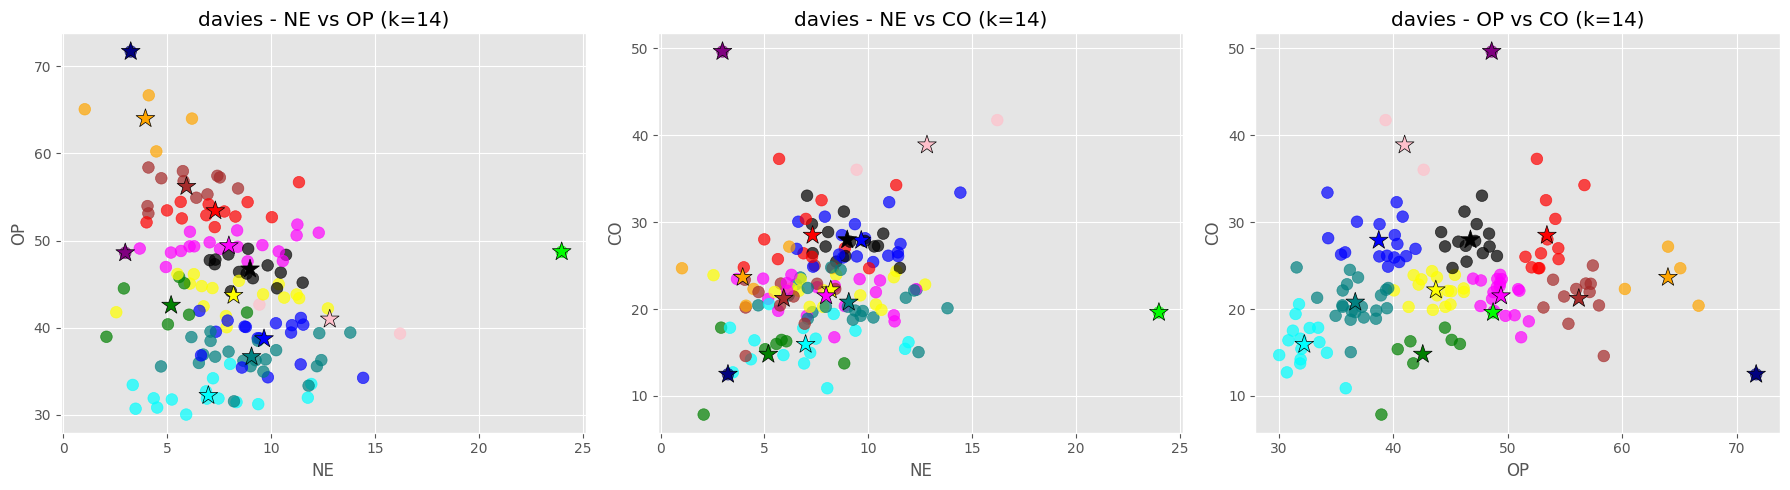

In [74]:
f1_name, f2_name, f3_name = seleccionadas[0], seleccionadas[1], seleccionadas[2]
f1 = dataframe[f1_name].values
f2 = dataframe[f2_name].values
f3 = dataframe[f3_name].values

for name, km in models.items():
    labels = km.predict(x)
    asignar = [colores[l] if l < len(colores) else "gray" for l in labels]
    C = km.cluster_centers_

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # feature 0 vs 1
    axs[0].scatter(f1, f2, c=asignar[:len(f1)], s=70, alpha=0.7)  # Asegúrate de que 'asignar' tenga la longitud correcta
    axs[0].scatter(C[:,0], C[:,1], marker="*", c=colores[:km.n_clusters], s=200, edgecolor="k")
    axs[0].set_xlabel(f1_name.upper()); axs[0].set_ylabel(f2_name.upper())
    axs[0].set_title(f"{name} - {f1_name.upper()} vs {f2_name.upper()} (k={km.n_clusters})")

    # feature 0 vs 2
    axs[1].scatter(f1, f3, c=asignar[:len(f1)], s=70, alpha=0.7)  # Asegúrate de que 'asignar' tenga la longitud correcta
    axs[1].scatter(C[:,0], C[:,2], marker="*", c=colores[:km.n_clusters], s=200, edgecolor="k")
    axs[1].set_xlabel(f1_name.upper()); axs[1].set_ylabel(f3_name.upper())
    axs[1].set_title(f"{name} - {f1_name.upper()} vs {f3_name.upper()} (k={km.n_clusters})")

    # feature 1 vs 2
    axs[2].scatter(f2, f3, c=asignar[:len(f2)], s=70, alpha=0.7)  # Asegúrate de que 'asignar' tenga la longitud correcta
    axs[2].scatter(C[:,1], C[:,2], marker="*", c=colores[:km.n_clusters], s=200, edgecolor="k")
    axs[2].set_xlabel(f2_name.upper()); axs[2].set_ylabel(f3_name.upper())
    axs[2].set_title(f"{name} - {f2_name.upper()} vs {f3_name.upper()} (k={km.n_clusters})")

    plt.tight_layout()
    plt.show()

Analisis de cantidad y diversidad por cada modelo

In [75]:
for name, km in models.items():
    labels = km.predict(x)
    
    # Crear DataFrame con usuario, categoría y label del cluster
    copy = pd.DataFrame()
    copy["usuario"] = dataframe["usuario"].values
    copy["categoria"] = dataframe["categoria"].values
    copy["label"] = labels
    
    # Cantidad de usuarios por cluster
    print(f"\n{'='*60}")
    print(f"Modelo: {name} (k={km.n_clusters})")
    print(f"{'='*60}")
    print("\nCantidad de usuarios por cluster:")
    cantidadGrupo = pd.DataFrame()
    cantidadGrupo["Color"] = colores[:km.n_clusters]
    cantidadGrupo["Cluster"] = range(km.n_clusters)
    cantidadGrupo["Cantidad"] = [np.sum(labels == i) for i in range(km.n_clusters)]
    print(cantidadGrupo.to_string(index=False))
    
    # Diversidad de categorías por cada cluster
    print(f"\nDiversidad de categorías por cluster:")
    for cluster_id in range(km.n_clusters):
        cluster_data = copy[copy["label"] == cluster_id]
        categoria_counts = cluster_data.groupby("categoria").size()
        print(f"\n  Cluster {cluster_id} ({colores[cluster_id]}):")
        print(f"    {dict(categoria_counts)}")


Modelo: elbow (k=3)

Cantidad de usuarios por cluster:
Color  Cluster  Cantidad
 blue        0        43
  red        1        46
green        2        51

Diversidad de categorías por cluster:

  Cluster 0 (blue):
    {1: np.int64(11), 2: np.int64(20), 3: np.int64(6), 4: np.int64(4), 5: np.int64(1), 7: np.int64(1)}

  Cluster 1 (red):
    {1: np.int64(5), 2: np.int64(7), 3: np.int64(1), 4: np.int64(11), 5: np.int64(3), 6: np.int64(1), 7: np.int64(6), 8: np.int64(8), 9: np.int64(4)}

  Cluster 2 (green):
    {1: np.int64(11), 2: np.int64(7), 3: np.int64(2), 4: np.int64(4), 6: np.int64(7), 7: np.int64(10), 8: np.int64(8), 9: np.int64(2)}

Modelo: silhouette (k=2)

Cantidad de usuarios por cluster:
Color  Cluster  Cantidad
 blue        0        73
  red        1        67

Diversidad de categorías por cluster:

  Cluster 0 (blue):
    {1: np.int64(9), 2: np.int64(9), 3: np.int64(1), 4: np.int64(14), 5: np.int64(3), 6: np.int64(5), 7: np.int64(14), 8: np.int64(13), 9: np.int64(5)}

  Clu

Para finalizar, se debe categorizar cada grupo con respecto a sus profesiones, para este ejemplo se va a identificar cuantas de esas profesiones pertenecen al cluster rojo (0)

In [76]:
categorias_nombres = {
    0: "Ninguno",
    1: "Actor/Actriz",
    2: "Cantante",
    3: "Modelo",
    4: "TV, Series",
    5: "Radio",
    6: "Tecnologia",
    7: "Deportes",
    8: "Politica",
    9: "Escritores",
}


for name, km in models.items():
    labels = km.predict(x)
    
    print(f"\n{'='*80}")
    print(f"MODELO: {name.upper()} (k={km.n_clusters})")
    print(f"{'='*80}")
    
    # Por cada cluster, mostrar la diversidad de categorías
    for cluster_id in range(km.n_clusters):
        cluster_index = labels == cluster_id
        cluster_data = dataframe[cluster_index]
        
        # Contar categorías en este cluster
        categoria_counts = cluster_data["categoria"].value_counts().sort_index()
        
        print(f"\n{'─'*80}")
        print(f"Cluster {cluster_id} ({colores[cluster_id]}) - Total usuarios: {len(cluster_data)}")
        print(f"{'─'*80}")
        
        # Mostrar distribución de categorías
        for cat_id, count in categoria_counts.items():
            porcentaje = (count / len(cluster_data)) * 100
            cat_name = categorias_nombres.get(cat_id, "Desconocida")
            print(f"  {cat_name:20s} ({cat_id}): {count:3d} usuarios ({porcentaje:5.1f}%)")
        
        # Mostrar usuarios en este cluster
        print(f"\n  Usuarios en cluster {cluster_id}:")
        usuarios_cluster = cluster_data[["usuario", "categoria"]].copy()
        usuarios_cluster["categoria_nombre"] = usuarios_cluster["categoria"].map(categorias_nombres)
        for idx, row in usuarios_cluster.iterrows():
            print(f"    - {row['usuario']:25s} ({row['categoria_nombre']})")


MODELO: ELBOW (k=3)

────────────────────────────────────────────────────────────────────────────────
Cluster 0 (blue) - Total usuarios: 43
────────────────────────────────────────────────────────────────────────────────
  Actor/Actriz         (1):  11 usuarios ( 25.6%)
  Cantante             (2):  20 usuarios ( 46.5%)
  Modelo               (3):   6 usuarios ( 14.0%)
  TV, Series           (4):   4 usuarios (  9.3%)
  Radio                (5):   1 usuarios (  2.3%)
  Deportes             (7):   1 usuarios (  2.3%)

  Usuarios en cluster 0:
    - AngelAlessandra           (Modelo)
    - aplusk                    (Actor/Actriz)
    - AvrilLavigne              (Cantante)
    - BarRefaeli                (Modelo)
    - britneyspears             (Cantante)
    - carmenelectra             (Modelo)
    - CindyCrawford             (Modelo)
    - CourteneyCox              (Actor/Actriz)
    - Courtney                  (Cantante)
    - Cristiano                 (Deportes)
    - enrique305      

Distancias: Euclidiana, Manhattan, Laveshtein, Mahalanobis

In [77]:
distancias = [
    ('euclidean', {}),
    ('manhattan', {}),
    ('minkowski', {'p': 3}),
    ('hamming', {})
]

for name, km in models.items():
    print(f"\n{'='*80}")
    print(f"MODELO: {name.upper()} (k={km.n_clusters})")
    print(f"{'='*80}\n")
    
    # Para cada métrica de distancia
    for metrica_name, params in distancias:
        print(f"\n  Métrica: {metrica_name.upper()}")
        print(f"  {'-'*76}")
        
        # Calcular distancias con la métrica especificada
        dist_matrix = pairwise_distances(km.cluster_centers_, x, metric=metrica_name, **params)
        
        # Encontrar el usuario más cercano a cada centroide
        print(f"  Usuario más cercano a cada centroide:\n")
        for cluster_id in range(km.n_clusters):
            closest_idx = np.argmin(dist_matrix[cluster_id])
            user_name = dataframe["usuario"].values[closest_idx]
            user_category = dataframe["categoria"].values[closest_idx]
            cat_name = categorias_nombres.get(user_category, "Desconocida")
            distance = dist_matrix[cluster_id, closest_idx]
            
            print(f"    Cluster {cluster_id} ({colores[cluster_id]}): {user_name:30s} ({cat_name:15s}) - Distancia: {distance:.4f}")


MODELO: ELBOW (k=3)


  Métrica: EUCLIDEAN
  ----------------------------------------------------------------------------
  Usuario más cercano a cada centroide:

    Cluster 0 (blue): MariahCarey                    (Cantante       ) - Distancia: 1.7140
    Cluster 1 (red): alfredocasero1                 (TV, Series     ) - Distancia: 1.3459
    Cluster 2 (green): jimlangevin                    (Politica       ) - Distancia: 1.4274

  Métrica: MANHATTAN
  ----------------------------------------------------------------------------
  Usuario más cercano a cada centroide:

    Cluster 0 (blue): MariahCarey                    (Cantante       ) - Distancia: 2.6699
    Cluster 1 (red): _josecoronado_                 (Actor/Actriz   ) - Distancia: 1.8653
    Cluster 2 (green): jimlangevin                    (Politica       ) - Distancia: 2.0876

  Métrica: MINKOWSKI
  ----------------------------------------------------------------------------
  Usuario más cercano a cada centroide:

    Cl

Clasificar un dato sintetico usando Kmeans (modelos que usamos)

In [78]:
x_new = np.array([[45.92, 57.74, 15.66]])

print(f"\n{'='*80}")
print("CLASIFICACIÓN DE DATO SINTÉTICO")
print(f"{'='*80}\n")
print(f"Valores: OP={x_new[0,0]}, EX={x_new[0,1]}, AG={x_new[0,2]}\n")

for name, km in models.items():
    cluster_asignado = km.predict(x_new)[0]
    distancias = pairwise_distances(x_new, km.cluster_centers_)[0]
    
    print(f"{name.upper()}: Cluster {cluster_asignado}")
    print(f"  Distancias a todos los centroides: {distancias}")
    print()


CLASIFICACIÓN DE DATO SINTÉTICO

Valores: OP=45.92, EX=57.74, AG=15.66

ELBOW: Cluster 0
  Distancias a todos los centroides: [39.90820767 43.90749385 40.97964751]

SILHOUETTE: Cluster 1
  Distancias a todos los centroides: [42.798779  39.9410098]

CALINSKI: Cluster 1
  Distancias a todos los centroides: [42.798779  39.9410098]

DAVIES: Cluster 11
  Distancias a todos los centroides: [42.74181228 40.90993566 43.47830433 46.56392294 40.78560399 43.17560705
 40.4609989  43.77183378 40.40931505 55.51714784 39.29879607 24.05319679
 42.77191022 45.01382312]



Resultados


MÉTRICAS DE EVALUACIÓN POR MODELO


────────────────────────────────────────────────────────────────────────────────
MODELO: ELBOW (k=3)
────────────────────────────────────────────────────────────────────────────────

  Accuracy:  0.0857
  Precision: 0.0543
  Recall:    0.0857
  F1-Score:  0.0664
  ROC-AUC:   0.4575


────────────────────────────────────────────────────────────────────────────────
MODELO: SILHOUETTE (k=2)
────────────────────────────────────────────────────────────────────────────────

  Accuracy:  0.1286
  Precision: 0.0518
  Recall:    0.1286
  F1-Score:  0.0739
  ROC-AUC:   0.5225


────────────────────────────────────────────────────────────────────────────────
MODELO: CALINSKI (k=2)
────────────────────────────────────────────────────────────────────────────────

  Accuracy:  0.1286
  Precision: 0.0518
  Recall:    0.1286
  F1-Score:  0.0739
  ROC-AUC:   0.5225


────────────────────────────────────────────────────────────────────────────────
MODELO: DAVIES (k=1

C:\Users\LuKGa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\LuKGa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\LuKGa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\LuKGa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python

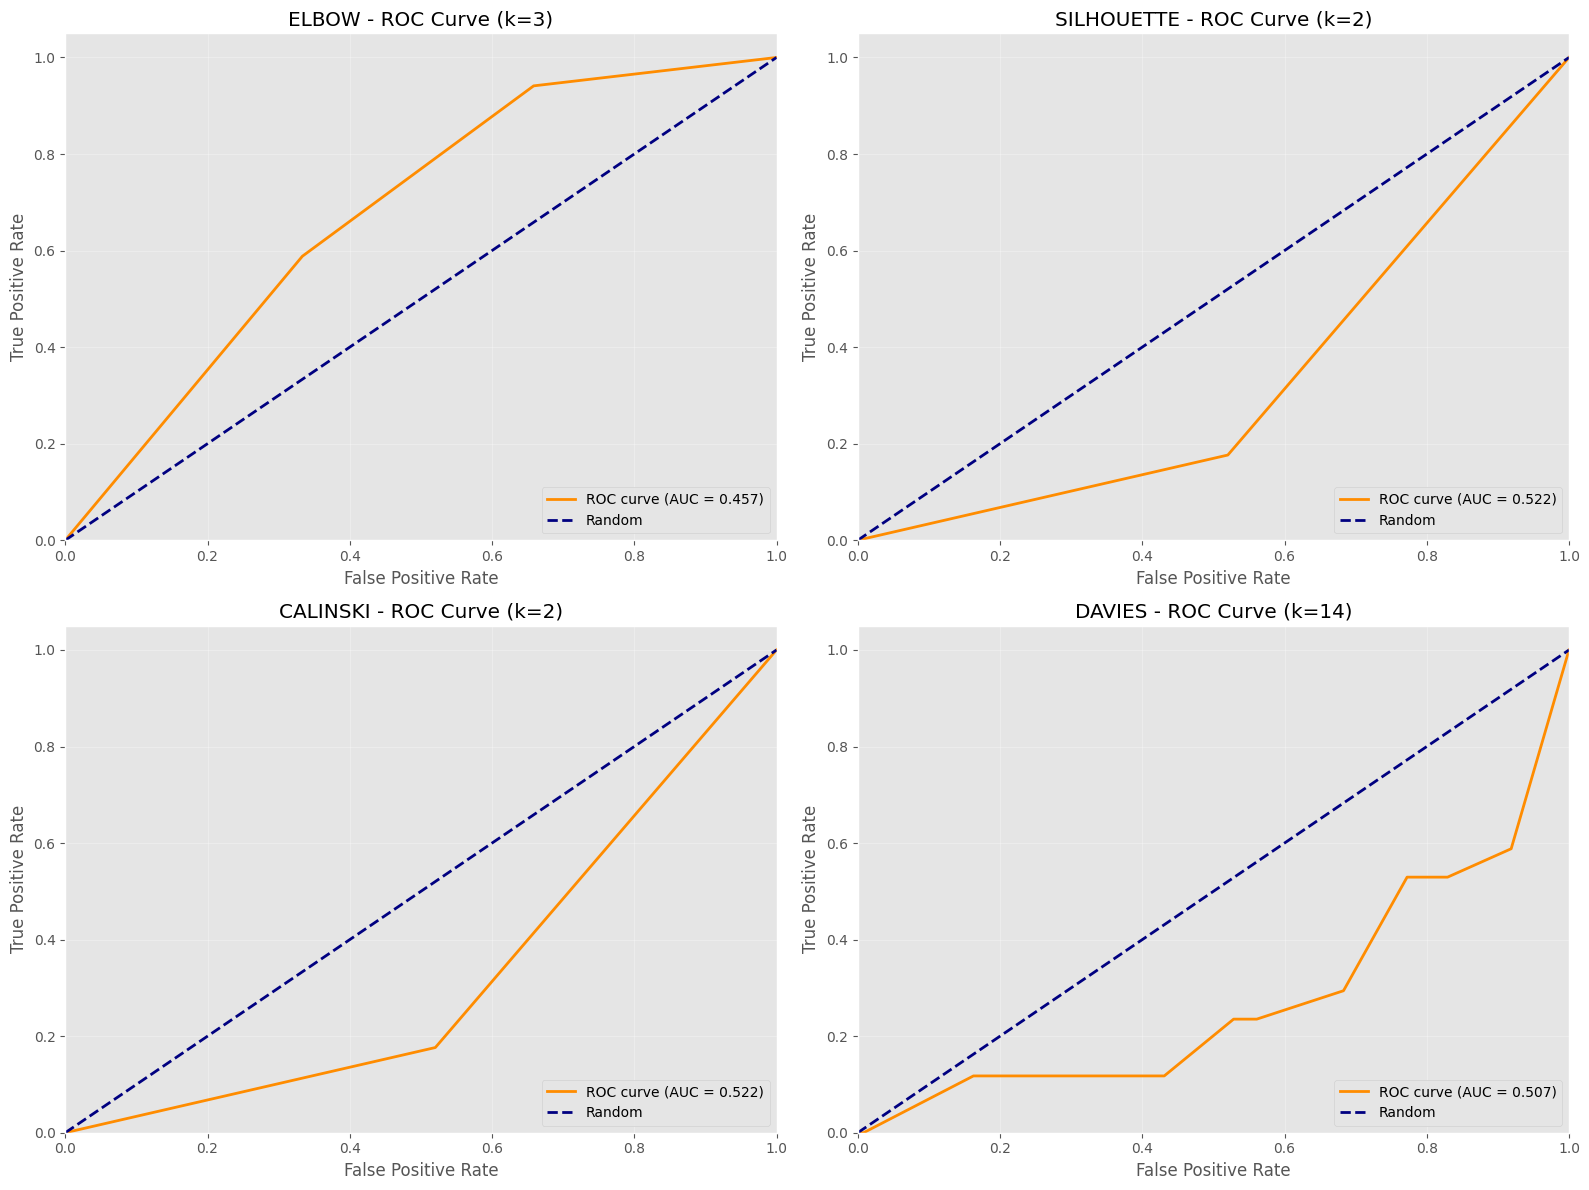


MATRICES DE CONFUSIÓN



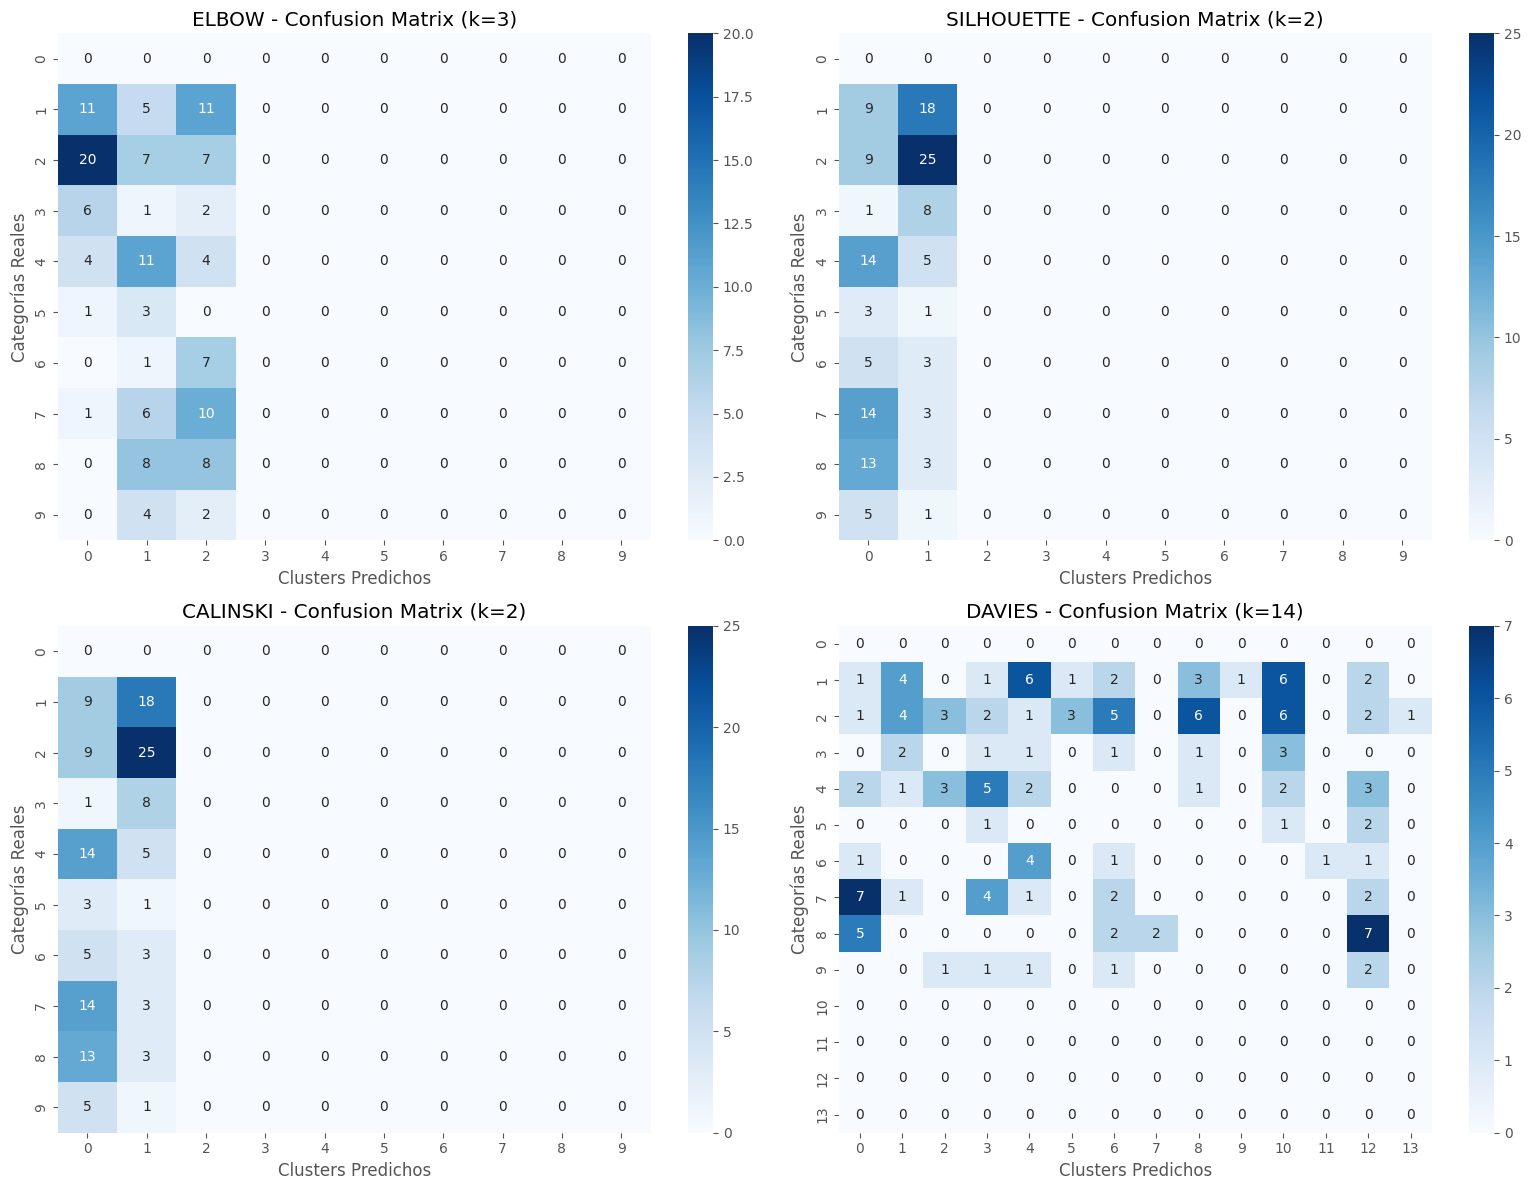


RESUMEN COMPARATIVO DE MÉTRICAS

            accuracy  precision    recall        f1   roc_auc
elbow       0.085714   0.054296  0.085714  0.066419  0.457465
silhouette  0.128571   0.051812  0.128571  0.073860  0.522472
calinski    0.128571   0.051812  0.128571  0.073860  0.522472
davies      0.078571   0.193699  0.078571  0.101163  0.507140


In [79]:
print(f"\n{'='*80}")
print("MÉTRICAS DE EVALUACIÓN POR MODELO")
print(f"{'='*80}\n")

# Binarizar las etiquetas reales para cálculo de ROC
y_true = y  # categorías reales

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

metricas_resultados = {}

for idx, (name, km) in enumerate(models.items()):
    print(f"\n{'─'*80}")
    print(f"MODELO: {name.upper()} (k={km.n_clusters})")
    print(f"{'─'*80}\n")
    
    # Predecir clusters
    y_pred = km.predict(x)
    
    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    metricas_resultados[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Calcular ROC-AUC (One-vs-Rest)
    try:
        y_bin = label_binarize(y_true, classes=range(max(y_true) + 1))
        y_pred_bin = label_binarize(y_pred, classes=range(max(y_true) + 1))
        
        roc_auc = roc_auc_score(y_bin, y_pred_bin, average='weighted', multi_class='ovr')
        print(f"  ROC-AUC:   {roc_auc:.4f}\n")
        metricas_resultados[name]['roc_auc'] = roc_auc
        
        # Graficar ROC curve (CORREGIDO)
        fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=y_true[0])
        axes[idx].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        axes[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'{name.upper()} - ROC Curve (k={km.n_clusters})')
        axes[idx].legend(loc="lower right")
        axes[idx].grid(alpha=0.3)
    except Exception as e:
        print(f"  ROC-AUC:   Error - {str(e)}\n")

plt.tight_layout()
plt.show()

# Matrices de confusión para cada modelo
print(f"\n{'='*80}")
print("MATRICES DE CONFUSIÓN")
print(f"{'='*80}\n")

fig_cm, axes_cm = plt.subplots(2, 2, figsize=(16, 12))
axes_cm = axes_cm.ravel()

for idx, (name, km) in enumerate(models.items()):
    y_pred = km.predict(x)
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Graficar heatmap
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes_cm[idx], cbar=True)
    axes_cm[idx].set_title(f'{name.upper()} - Confusion Matrix (k={km.n_clusters})')
    axes_cm[idx].set_xlabel('Clusters Predichos')
    axes_cm[idx].set_ylabel('Categorías Reales')

plt.tight_layout()
plt.show()

# Resumen comparativo
print(f"\n{'='*80}")
print("RESUMEN COMPARATIVO DE MÉTRICAS")
print(f"{'='*80}\n")

df_metricas = pd.DataFrame(metricas_resultados).T
print(df_metricas.to_string())